## Objective
VSS 7/13/23

## General setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
from pathlib import Path

In [30]:
# Load recording and model's detected spikes

from spikeinterface import load_extractor
from src.recording import Recording

RECORDING = load_extractor("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/spike_band.si")
RECORDING = Recording(RECORDING)

MODEL_ROOT = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120")
PROP_ROOT = MODEL_ROOT / "prop_signal"
# PROP_ROOT.mkdir(exist_ok=False)

FIRST_SECONDS = 60

MODEL_TIMES = np.load(MODEL_ROOT / "spike_times.npy", allow_pickle=True)
model_times = []
for times in MODEL_TIMES:
    times = np.array(times)
    times = times[times <= FIRST_SECONDS * 1000]
    model_times.append(times)
MODEL_TIMES = model_times
del model_times

MODEL_AMPS = np.load(MODEL_ROOT / "spike_amps.npy", allow_pickle=True)

chans_rms = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/chans_rms.npy")

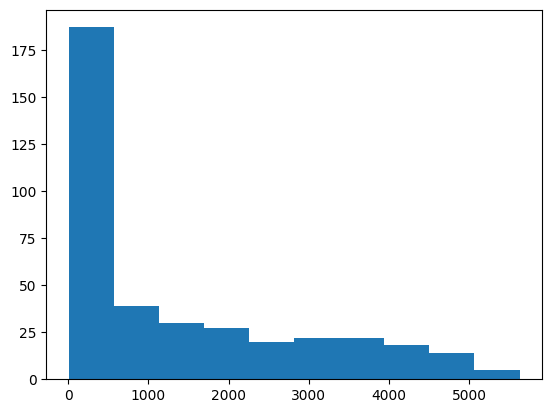

In [6]:
import matplotlib.pyplot as plt
num_times = [len(times) for times in MODEL_TIMES]
plt.hist(num_times)
plt.show()

## Create units

### Model output spread

### Detect sequences

In [7]:
# Create candidate cohorts
from src.prop_signal import v1_4 as ps_alg

MIN_PROP_SPIKES = 1 * FIRST_SECONDS  # min_firing_rate * mins * 60_seconds_per_min

candidate_cohorts = ps_alg.scan_reference_electrode(MODEL_TIMES, sampling_freq=30, min_prop_spikes=MIN_PROP_SPIKES, min_ccg_ratio=0.5,
                                                    ccg_before=1.5, ccg_after=1.5, ccg_small_window=0.5, ccg_big_window=2)

# import pickle
# with open(PROP_ROOT / "candidate_cohorts.pkl", "wb") as file:
#         pickle.dump(candidate_cohorts, file)
        
# import pickle
# with open(PROP_ROOT / "candidate_cohorts.pkl", "rb") as file:
#     candidate_cohorts = pickle.load(file)
# import pickle
# with open("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/prop_signal/candidate_cohorts.pkl", "rb") as file:
#     candidate_cohorts = pickle.load(file)


Scanning reference electrodes ...


100%|██████████| 384/384 [00:49<00:00,  7.81it/s]


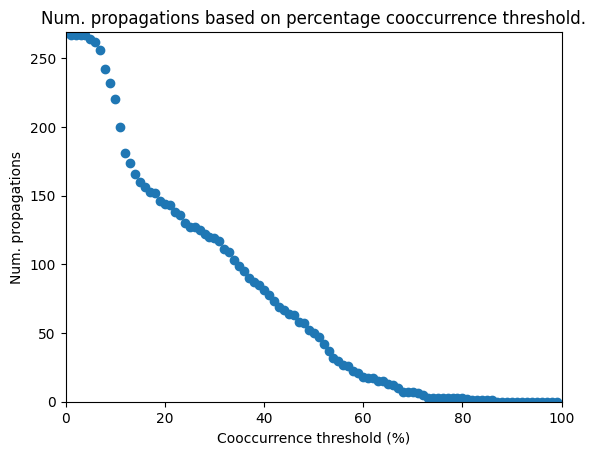

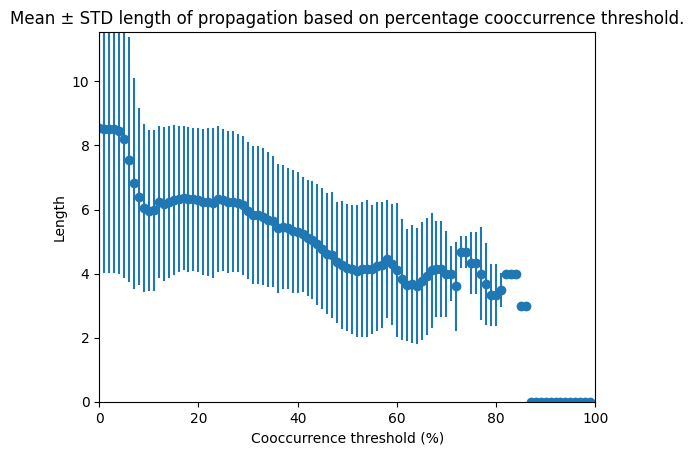

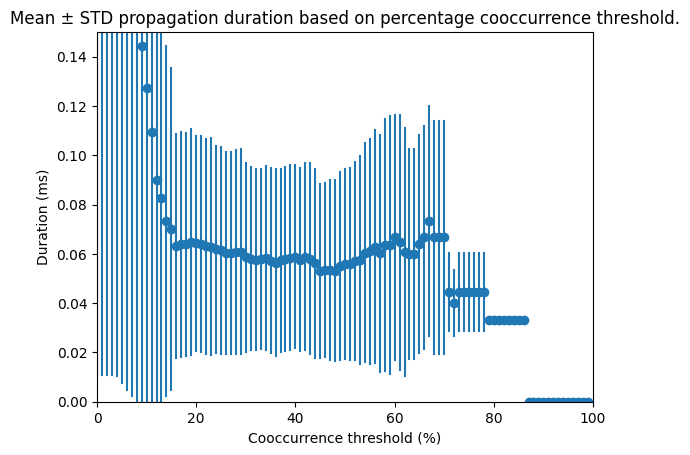

In [8]:
from src.sorters.prop_signal import PropSignal

MIN_COCS_P_VALUES = range(0, 100)
##
nums_props = []

means_lens = []
stds_lens = []

means_durations = []
stds_durations = []
for min_cocs_p in MIN_COCS_P_VALUES:
    electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                        min_cocs_n=0, min_cocs_p=min_cocs_p,
                                                        min_cocs_2_p=50)
    propagations = ps_alg.get_propagations(electrode_cohorts, min_duration=0.001)

    prop_lens = [len(p) for p in propagations]
    nums_props.append(len(prop_lens))

    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))

        prop_durations = [PropSignal.get_sequence_duration(p) for p in propagations]
        means_durations.append(np.mean(prop_durations))
        stds_durations.append(np.std(prop_durations))
    else:
        means_lens.append(0)
        stds_lens.append(0)

        means_durations.append(0)
        stds_lens.append(0)

plt.title("Num. propagations based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Num. propagations")
plt.scatter(MIN_COCS_P_VALUES, nums_props)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, max(nums_props)+1)
plt.show()

plt.title("Mean ± STD length of propagation based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Length")
plt.scatter(MIN_COCS_P_VALUES, means_lens)
y_max = max(means_lens)+3
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

plt.title("Mean ± STD propagation duration based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Duration (ms)")
plt.scatter(MIN_COCS_P_VALUES, means_durations)
y_max = 0.15
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_durations, stds_durations):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

In [9]:
# Form propagations
electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                    min_cocs_n=0, min_cocs_p=30,  # 40  
                                                    min_cocs_2_p=50)
propagations = ps_alg.get_propagations(electrode_cohorts, 0.001)
len(propagations)

119

In [10]:
chans_rms = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/chans_rms.npy")

### Build model output templates

In [11]:
# Find which spike detections contributed to propagation being formed i.e. start electrode + at least one other electrode coactivate 

from tqdm import tqdm

MODEL_AMPS = np.load(
    MODEL_ROOT / "spike_amps.npy",
    allow_pickle=True
)

PROP_AFTER = 0.5  # Coactivations must occur within PROP_AFTER ms
MIN_COACTIVATIONS = 2 # -1  # -1 = all electrodes must have spike, 
ISI_VIOL = 1.5

def get_prop_times_and_amps(prop, min_coactivations):
    """
    For one propagation
    
    ref = crossing of first/anchor electrode in prop
    tar = crossing of another electrode in prop
    """
    
    if min_coactivations == -1:
        min_coactivations = len(prop)

    # min_coactivations = max(2, ceil(len(prop) / 2))

    if len(prop) < min_coactivations:
        return np.array([]), np.array([np.nan for _ in range(len(prop))])
    
    ref_elec = prop.ID[0]
    ref_cross_times = MODEL_TIMES[ref_elec]
    ref_cross_amps = MODEL_AMPS[ref_elec]
    
    propagating_data = {}  # (ref_time, ref_amp) : [(tar1_elec, tar1_amp), (tar2_elec, tar2_amp), ...]
    for tar_elec in prop.ID[1:]:
        tar_cross_times = MODEL_TIMES[tar_elec]
        tar_cross_amps = MODEL_AMPS[tar_elec]
        
        for ref_time, ref_amp in zip(ref_cross_times, ref_cross_amps):
            # Find closest target cross
            i_tar = np.searchsorted(tar_cross_times, ref_time, side="left")
            
            # Count as coactivation if within PROP_AFTER
            if i_tar < len(tar_cross_times) and tar_cross_times[i_tar] <= ref_time + PROP_AFTER:
                ref = (ref_time, ref_amp)
                tar = (tar_elec, tar_cross_amps[i_tar])
                if ref not in propagating_data:
                    propagating_data[ref] = [tar]
                else:
                    propagating_data[ref].append(tar)
                    
    keys = list(propagating_data.keys())
    ref_times = [k[0] for k in keys]
    order = np.argsort(ref_times)
        
    propagating_times = []
    propagating_amps = {elec: [] for elec in prop.ID.values}  # elec : amps
    last_ref_time = -np.inf
    for idx in order:
        
        ref_time, ref_amp = keys[idx]
        tars = propagating_data[keys[idx]]
        if len(tars) + 1 < min_coactivations:  # +1 since being in list counts as 2 coactivations
            continue
        
        if ref_time <= last_ref_time + ISI_VIOL:  # ISI violation
            continue
        last_ref_time = ref_time
        
        propagating_times.append(ref_time)
        propagating_amps[ref_elec].append(ref_amp)
        for elec, amp in tars:
            propagating_amps[elec].append(amp)
        
    propagating_amps = np.array([np.mean(amps) for amps in propagating_amps.values()])
    
    return propagating_times, propagating_amps
        

def get_propagating_times_and_amps_all():
    # For all propagations
    propagating_times = []
    propagating_amps = []
    
    for prop in tqdm(propagations):
        prop_times, prop_amps = get_prop_times_and_amps(prop, MIN_COACTIVATIONS)
        propagating_times.append(prop_times)
        propagating_amps.append(prop_amps)
        
    return propagating_times, propagating_amps


propagating_times, propagating_amps = get_propagating_times_and_amps_all()

100%|██████████| 119/119 [00:05<00:00, 20.28it/s]


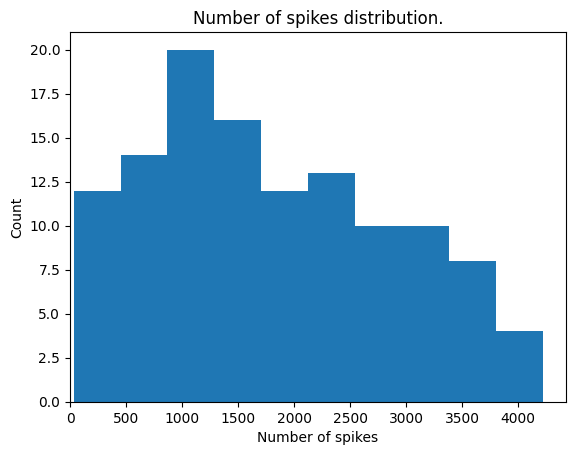

Mean: 1800.84
STD: 1082.37


In [12]:
prop_signal = PropSignal([[[p] for p in propagations], propagating_times], RECORDING)
prop_signal.plot_nums_spikes()

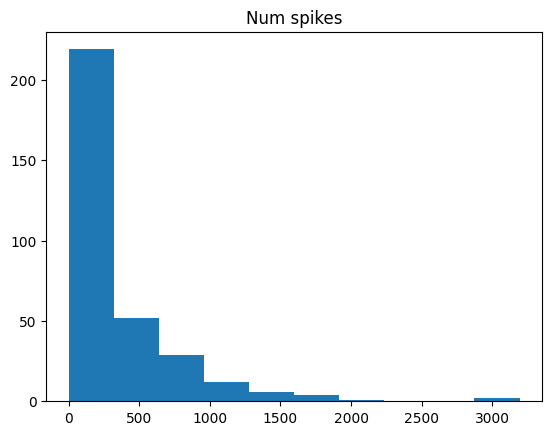

In [20]:
from src.sorters.kilosort import Kilosort
from src.comparison import DummySorter, Comparison

kilosort = Kilosort(
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/spikesort_matlab4",
    "first",
    RECORDING
)

ks_times = []
for times in kilosort.get_spike_times():
    times = times[times < FIRST_SECONDS * 1000]
    if len(times) > 0:
        ks_times.append(times)
kilosort = DummySorter(ks_times, "Kilosort")

plt.title("Num spikes")
plt.hist([len(st) for st in ks_times])
plt.show()
        

Num Prop.: 119
Num Kilosort: 325
Num single matches: 102

For Prop.:
Num max matches: 106
Num unique max matches: 49

For Kilosort:
Num max matches: 196
Num unique max matches: 73


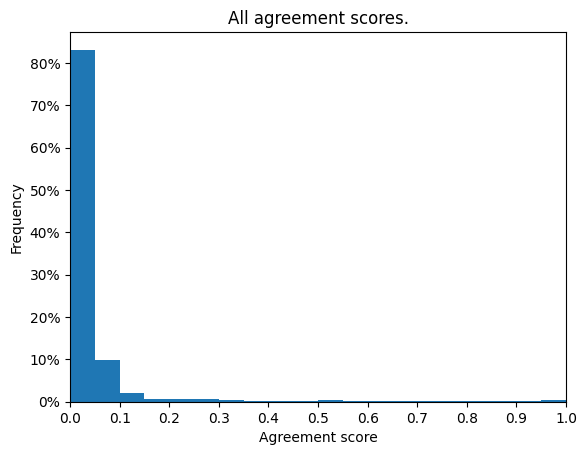

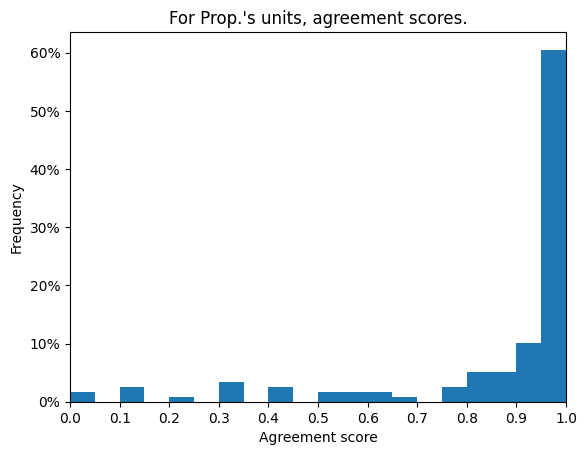

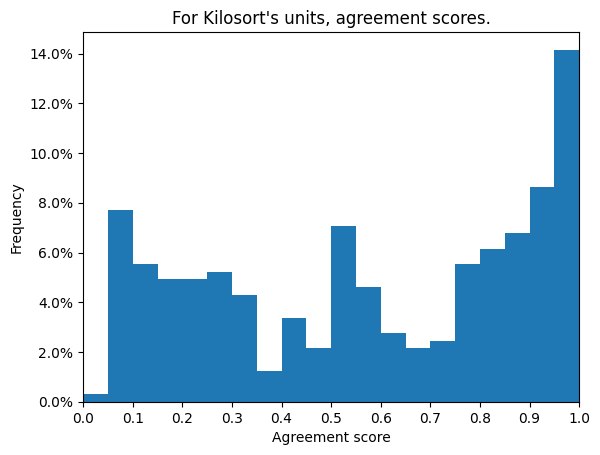

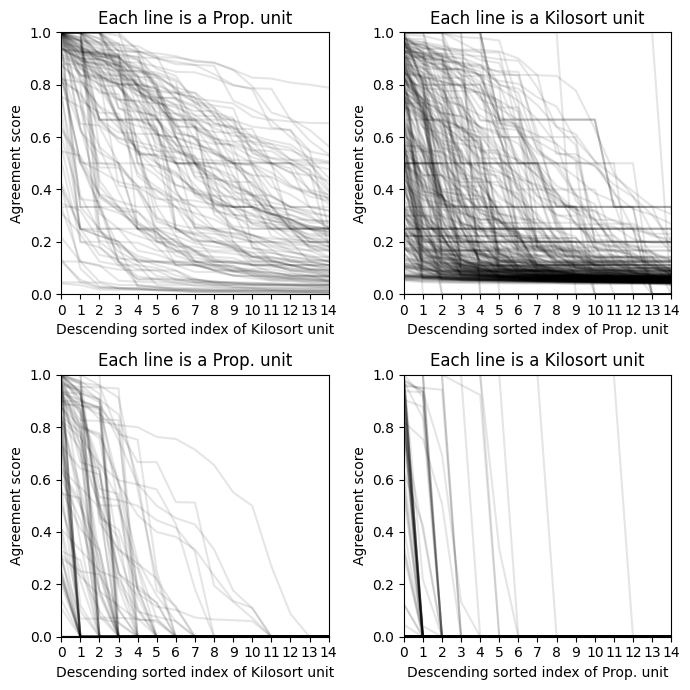

In [22]:
comp = Comparison(prop_signal, kilosort, score_formula=2)
comp.summary()
comp.plot_line_comps()

0


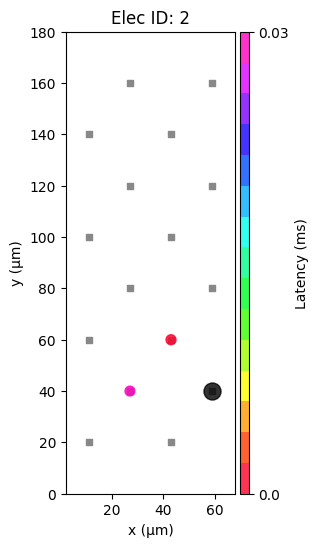

1


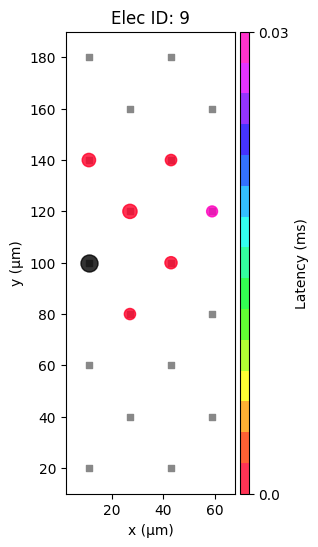

In [23]:
for p in range(0, 2):
    print(p)
    prop_signal[p].plot()

In [24]:
MODEL_OUTPUTS = np.load(
    MODEL_ROOT / "outputs.npy",
    mmap_mode="r"
)
FRONT_BUFFER = 40  # Model's front sample buffer

def time_to_output_frame(time_ms):
    # Convert time to frame in model outputs.npy
    # time = time_ms * RECORDING.get_sampling_frequency()
    # return int(time) - FRONT_BUFFER
    return round(time_ms * 30) - FRONT_BUFFER

def sigmoid(x):
    # return np.where(x>=0,
    #                 1 / (1 + np.exp(x)),
    #                 np.exp(x) / (1+np.exp(x))
    #                 )
    return np.exp(x) / (1+np.exp(x))  # Positive overflow is not an issue because DL does not output large positive values (only large negative)
    

In [25]:
N_BEFORE = int(0.5 * RECORDING.get_sampling_frequency())
N_AFTER = int(0.5 * RECORDING.get_sampling_frequency())

unit_templates = []
for times in tqdm(propagating_times):
    template = []
    for time in times:
        time = time_to_output_frame(time)
        
        output = MODEL_OUTPUTS[:, time-N_BEFORE:time+N_AFTER]
        output = sigmoid(output)
        
        template.append(output)
    template = np.array(template)
    template = np.mean(template, axis=0)
    
    unit_templates.append(template)
    
unit_templates = np.array(unit_templates)

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [05:00<00:00,  2.53s/it]


In [26]:
np.save("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120/230713/60_sec/unit_templates.npy", unit_templates)

In [32]:
# unit_templates = np.load(PROP_ROOT / "unit_templates.npy", mmap_mode="r")

In [33]:
# from src.sorters.prop_signal import PropSignal
# prop_signal = PropSignal([[p for p in propagations], propagating_times], RECORDING)
# prop_signal.save(PROP_ROOT)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#### Plot some templates

In [31]:
import matplotlib.pyplot as plt

def plot_template(idx, dec=0.00):
    # x_values = np.arange(unit_templates.shape[-1]+1) - unit_templates.shape[-1]//2
    # x_values = x_values / 30
    # for i, c in enumerate(propagations[idx].ID):
    #     plt.plot(x_values, (unit_templates[idx, c, :]*100 - i * dec).tolist() + [0])
    # plt.title(idx)
    # plt.ylabel("Model's predicted probability (%)")
    # plt.xlabel("Time rel. trough of first electrode (ms)")
    # plt.xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
    # plt.xlim(-0.5, 0.5)
    # plt.show()
    
    x_values = np.arange(30) - 15
    for i, c in enumerate(propagations[idx].ID):
        plt.plot(x_values, unit_templates[idx, c, :]*100 - i*dec)
    plt.title(idx)
    plt.ylabel("Model's predicted probability (%)")
    plt.xlabel("Time rel. trough of first electrode (frames)")
    plt.xticks([-14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14])
   
    for x in [-3, -2, -1, 0, 1, 2, 3]:
        plt.axvline(x, color="black", alpha=0.2, linestyle="dashed")

    plt.show()

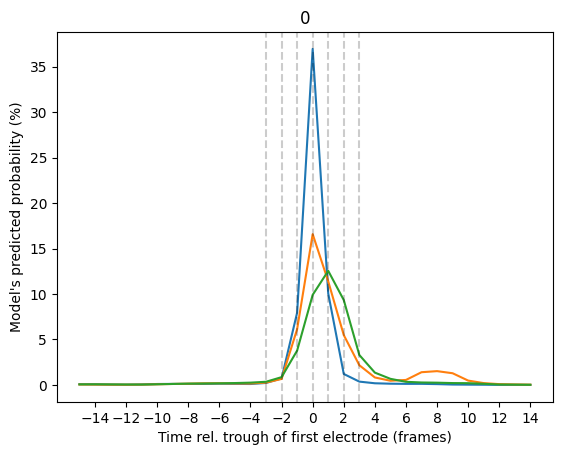

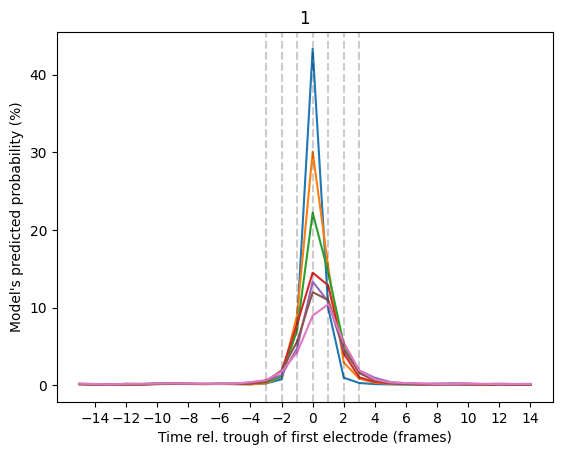

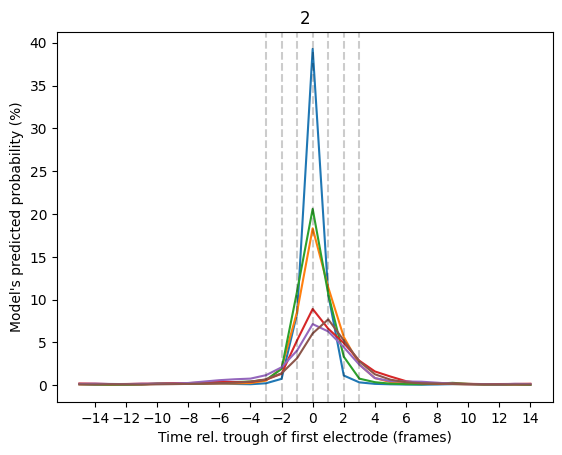

In [32]:
for i in range(0, 3):
    plt.title(i)
    plot_template(i)

## Detect spikes



In [13]:
prop = propagations[0]
prop

,ID,latency,small_window_cooccurrences,n1_n2_ratio
0,2,0.000000,2131.0,1.000000
1,4,0.000000,732.0,0.931298
2,3,0.033333,709.0,0.954240


In [84]:
PROP_AFTER = 0.5  # Coactivations must occur within PROP_AFTER ms
MIN_COACTIVATIONS = -0.5  # -0.5 # -1  # -1 = all electrodes must have spike, 
ISI_VIOL = 1.5

from tqdm import tqdm
from math import ceil

def get_prop_times_and_amps(prop, min_coactivations):
    """
    For one propagation
    
    ref = crossing of first/anchor electrode in prop
    tar = crossing of another electrode in prop
    """
    
    # Get min_coactivations for this prop 
    if min_coactivations == -1:  # All must spike
        min_coactivations = len(prop)
    elif min_coactivations == -0.5:  # Half must spike
        min_coactivations = ceil(len(prop) / 2) 

    # Skip propagation if it has too few electrodes
    if len(prop) < min_coactivations:
        return np.array([]), np.array([np.nan for _ in range(len(prop))])
    
    # Get data for ref electrode
    ref_elec_id = prop.ID[0]
    ref_cross_times = MODEL_TIMES[ref_elec_id]
    ref_cross_amps = MODEL_AMPS[ref_elec_id]
    
    # Get coactivations for each ref electrode spike
    # propagating_data = {}  # (ref_time, ref_amp) : [(tar1_elec, tar1_amp), (tar2_elec, tar2_amp), ...]
    # for i, tar_elec in prop.iterrows():
    #     tar_cross_times = MODEL_TIMES[int(tar_elec.ID)]
    #     tar_cross_amps = MODEL_AMPS[tar_elec.ID]
        
    #     for ref_time, ref_amp in ref_cross_times:
    #         # # Find closest target spike
    #         # i_tar = np.searchsorted(tar_cross_times, ref_time, side="left")
            
    #         # # Count as coactivation if within PROP_AFTER
    #         # if i_tar < len(tar_cross_times) and tar_cross_times[i_tar] <= ref_time + PROP_AFTER:
    #         #     ref = (ref_time, ref_amp)
    #         #     tar = (tar_elec, tar_cross_amps[i_tar])
    #         #     if ref not in propagating_data:
    #         #         propagating_data[ref] = [tar]
    #         #     else:
    #         #         propagating_data[ref].append(tar)
            
    propagating_times = {}  # {ref_time: [elecs that coactivate]}
    last_ref_time = -np.inf  # for ISI violations
    for ref_time, ref_amp in zip(ref_cross_times, ref_cross_amps):
        if ref_time - last_ref_time <= ISI_VIOL:
            continue
        
        coactivations = [ref_elec_id]
        for i, tar_elec in prop.iterrows():
            if i == 0:  # Skip reference electrode
                continue
            
            tar_elec_id = int(tar_elec.ID)
            tar_cross_times = MODEL_TIMES[tar_elec_id]
            tar_cross_amps = MODEL_TIMES[tar_elec_id]
            
            LATENCY_BUFFERS = [0] # [-0.03, 0, 0.03]
            for latency in LATENCY_BUFFERS:
                co_time = ref_time + latency  # time that tar_elec needs to spike
                tar_idx = np.searchsorted(tar_cross_times, co_time)
                if tar_idx < len(tar_cross_times):  # Prevent index out of bounds error
                    if np.abs(tar_cross_times[tar_idx] - ref_time) < 1e-9:  # Prevent rounding error
                        coactivations.append(tar_elec_id) # Add time to propagating_times
                        break
                    
        if len(coactivations) >= min_coactivations:
            propagating_times[ref_time] = coactivations
            last_ref_time = ref_time
            
    return propagating_times
                    

propagating_times = []
for prop in tqdm(propagations):
    propagating_times.append(
        list(get_prop_times_and_amps(prop, MIN_COACTIVATIONS).keys())
    )
    
# from src.sorters.prop_signal import PropUnit
# unit = PropUnit([prop], 0, list(get_prop_times_and_amps(prop, MIN_COACTIVATIONS).keys()), RECORDING)
# unit.plot_footprint(chans_rms=chans_rms)

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [01:27<00:00,  1.36it/s]


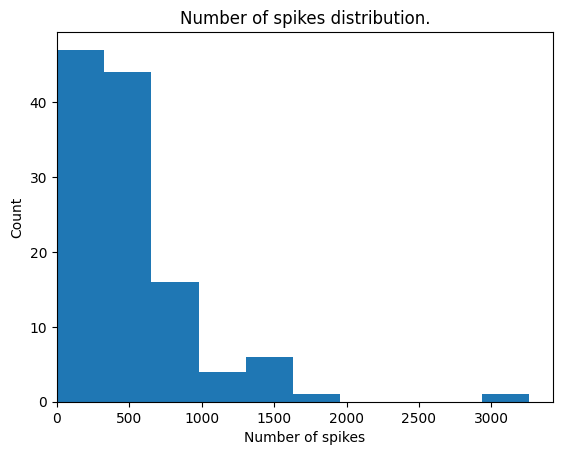

Mean: 483.50
STD: 444.09


In [85]:
prop_signal = PropSignal([[[p] for p in propagations], propagating_times], RECORDING)
prop_signal.plot_nums_spikes()

## Merge propagations

In [65]:
# Merge propagations
from scipy.cluster.hierarchy import fcluster, linkage
from math import ceil

MODEL_AMPS = np.load(MODEL_ROOT / "spike_amps.npy", allow_pickle=True)
PROP_AFTER = 0.5  # Coactivations must occur within PROP_AFTER ms
MIN_COACTIVATIONS = 2 # -1  # -1 = all electrodes must have spike, 
ISI_VIOL = 1.5

MERGE_METHOD = "average"

# Probably don't change this unless revamping merging process
MERGE_CRITERION = "distance"


def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b


def score_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return num_overlap, overlap_score * 100


def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            diff  = latencies[i] - latencies[j]
            pairs.append(diff)
            
    return np.asarray(pairs)


def score_seq_order(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    sums = np.sum(latencies_a) + np.sum(latencies_b)
    if sums < 0.0001:
        return 0
    
    pairs_a = get_latency_pairs(latencies_a)
    pairs_b = get_latency_pairs(latencies_b)
    seq_score = np.sum(np.abs(pairs_a - pairs_b))
    return seq_score / sums


def score_rel_amp(idx_a, idx_b, rel_first=False):
    """_summary_

    Args:
        idx_a (_type_): _description_
        idx_b (_type_): _description_
        rel_first (_type_): _description_
            Whether relative amps are relative to first electrode in prop
            or electrode with largest amplitude (very often not the same, like 110/144)
            
            It should be relative to maximum electrode because:
                if two propagations (A, b, c) and (b, A, c) (uppercase indicates maximum)
                should be merged, then order of electrodes (which is arbitrary when elecs have same latency)
                will be different, but max electrode should be the same.
    """
    prop_a = propagations[idx_a]
    prop_b = propagations[idx_b]
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    
    if overlap_a.size == 0:
        return np.nan
    
    amps_a = propagating_amps[idx_a]
    if rel_first:
        rel_amps_a = amps_a[overlap_a] / amps_a[0]
    else:
        rel_amps_a = amps_a[overlap_a] / np.max(amps_a)
    
    amps_b = propagating_amps[idx_b]
    if rel_first:
        rel_amps_b = amps_b[overlap_b] / amps_b[0]
    else:
        rel_amps_b = amps_b[overlap_b] / np.max(amps_b)
        
    diff = np.abs(rel_amps_a - rel_amps_b)
    return np.sum(diff) / diff.size

MERGE_METHOD = "average"

# Probably don't change this unless revamping merging process
MERGE_CRITERION = "distance"

from scipy.cluster.hierarchy import fcluster, linkage


def get_merge_scores():
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        prop_a = propagations[i_a]
        prop_b = propagations[i_b]

        elec_score_n, elec_score_p = score_elec_overlap(prop_a, prop_b)
        seq_score = score_seq_order(prop_a, prop_b)
        rel_amp_score = score_rel_amp(i_a, i_b)

        merge_scores.append([elec_score_n, elec_score_p, seq_score, rel_amp_score])
    return np.asarray(merge_scores)


def merge(dist_max, return_times=False, isi_viol=1.5):
    linkage_m = linkage(pdist, method=MERGE_METHOD)
    clusters = fcluster(linkage_m, dist_max, criterion=MERGE_CRITERION)
    
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])
          
    # IDK why pms are sorted by cluster ID
    # pm_order = sorted(c for c in propagations_merged.keys())
    # propagations_merged = [propagations_merged[c] for c in pm_order]
    
    # Sort pms by first electrode ID
    pm_ids = []
    elec_ids = []
    for p in propagations_merged.keys():
        pm_ids.append(p)
        elec_ids.append(min(prop.ID[0] for prop in propagations_merged[p]))
    pm_order = [pm_ids[e] for e in np.argsort(elec_ids)]
    propagations_merged = [propagations_merged[o] for o in pm_order]
        
    # Get spike times
    if not return_times:
        return propagations_merged
    else:
         # Get which propagation belongs to which merge 
        propagating_times_merged = {}
        for i, c in enumerate(clusters): 
            if c not in propagating_times_merged:
                propagating_times_merged[c] = propagating_times[i][:]
            else:
                propagating_times_merged[c].extend(propagating_times[i])
                
        # Sort propagation times and prevent ISI violations
        propagating_times_merged_sorted = []
        for c in pm_order:
            pu_times = propagating_times_merged[c]  # pu = propagations un-properly formatted 
            pu_times = np.sort(pu_times)
            
            last_time = pu_times[0]
            pm_times = [last_time]
            
            for t in range(1, pu_times.size):
                time = pu_times[t]
                if time - last_time > isi_viol:
                    pm_times.append(time)
                    last_time = time
            propagating_times_merged_sorted.append(np.array(pm_times))
    
        return propagations_merged, propagating_times_merged_sorted

merge_scores = get_merge_scores()

In [70]:
def get_merged_unit_templates(prop_m):
    # Get unit templates of propagations in a merge
    templates = []
    for prop in prop_m:
        for idx in range(len(propagations)):
            if prop is propagations[idx]:
                templates.append(unit_templates[idx])
    return templates

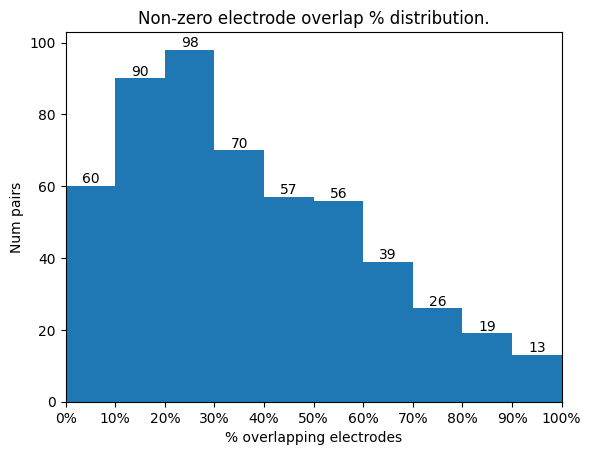

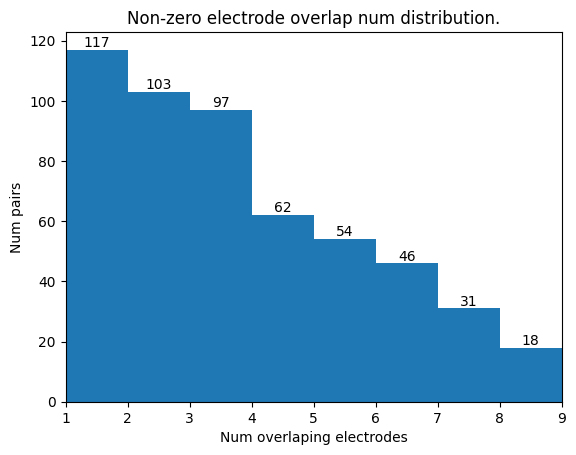

In [73]:
#### ELECTRODE OVERLAP ####

# Graph distribution of electrode overlap scores
nums = []
scores = []
ind_a, ind_b = np.triu_indices(len(propagations), k=1)
for i_a, i_b in zip(ind_a, ind_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]
    num, score = score_elec_overlap(prop_a, prop_b)
    
    if score > 0:
        scores.append(score)
        nums.append(num)
# Create plot
plt.title("Non-zero electrode overlap % distribution.")
plt.xlabel("% overlapping electrodes")
plot.hist(scores, bins=np.arange(0, 101, 10), labels=True)
plt.ylabel("Num pairs")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10), [f"{r}%" for r in np.arange(0, 101, 10)])
plt.show()

plt.title("Non-zero electrode overlap num distribution.")
plt.xlabel("Num overlaping electrodes")
plot.hist(nums, bins=max(nums)-1, labels=True)
plt.ylabel("Num pairs")
plt.xticks(np.arange(1, max(nums)+1))
plt.xlim(1, max(nums))
plt.show()

In [74]:
ELEC_OVERLAP_N_MIN = 2
ELEC_OVERLAP_P_MIN = 50

Num. propagations: 124


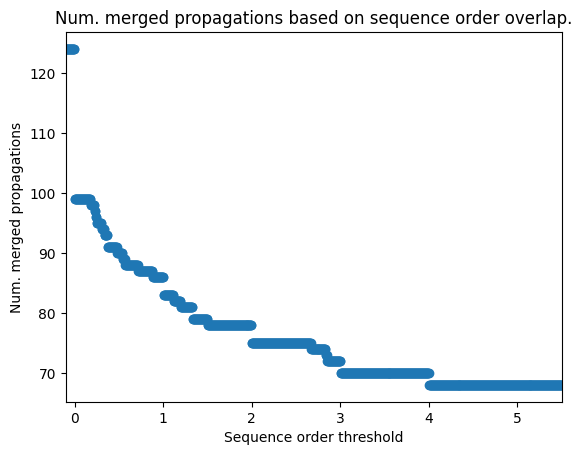

In [75]:
#### SEQUENCE ORDER ####
SEQ_ORDER_EXTREMUM = 500.6  # 5.1 # Value to assign prop pairs that should not be merged
SEQ_ORDER_MAX_VALUES = np.linspace(-0.1, 5.5, num=1000)  # Values to test in plot
##
no_merge_ind_elec = (merge_scores[:, 0] < ELEC_OVERLAP_N_MIN) | (merge_scores[:, 1] < ELEC_OVERLAP_P_MIN)

pdist = merge_scores[:, 2].copy()
pdist[no_merge_ind_elec] = SEQ_ORDER_EXTREMUM

nums_merges = []
means_lens = []
stds_lens = []
for seq_order_max in SEQ_ORDER_MAX_VALUES:
    prop_lens = [len(p) for p in merge(seq_order_max)]
    
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on sequence order overlap.")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_MAX_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_MAX_VALUES), max(SEQ_ORDER_MAX_VALUES))
# plt.ylim(40, len(propagations))
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
plt.hist(merge_scores[:, 3], range=(0, 1), bins=40)
plt.title("Relative amplitude overlap score distribution.")
plt.xlabel("Relative amplitude overlap score")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

In [ ]:
#### RELATIVE AMPLITUDE ####
REL_AMP_EXTREMUM = 10  # Value to assign prop pairs that should not be merged
REL_AMP_MAX_VALUES = np.linspace(0, 1, num=400)  # Values to test in plot

SEQ_ORDER_MAX_VALUES = [0, 0.4, 0.8, 1.5, 2, 5]
CMAP = plt.cm.get_cmap("viridis", len(SEQ_ORDER_MAX_VALUES))
##
norm = plt.Normalize(min(SEQ_ORDER_MAX_VALUES), 3)
for seq_order_max in SEQ_ORDER_MAX_VALUES:    
    no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > seq_order_max)

    pdist = merge_scores[:, 3].copy()
    pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

    nums_merges = []
    means_lens = []
    stds_lens = []
    for rel_amp_max in REL_AMP_MAX_VALUES:
        prop_lens = [len(p) for p in merge(rel_amp_max)]
        
        nums_merges.append(len(prop_lens))
        if len(prop_lens) > 0:
            means_lens.append(np.mean(prop_lens))
            stds_lens.append(np.std(prop_lens))
        else:
            means_lens.append(0)
            stds_lens.append(0)
            
    color = CMAP(norm(min(3, seq_order_max)))
    plt.scatter(REL_AMP_MAX_VALUES, nums_merges, color=color, label=seq_order_max, alpha=0.6)
# print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on relative amplitude overlap.")
plt.xlabel("Relative amplitude threshold")
plt.ylabel("Num. merged propagations")
# plt.scatter(REL_AMP_MAX_VALUES, nums_merges)
plt.xlim(min(REL_AMP_MAX_VALUES), max(REL_AMP_MAX_VALUES))
# plt.ylim(60, len(propagations))
plt.legend()
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
SEQ_ORDER_MAX = 0.8
REL_AMP_MAX = 0.2

In [ ]:
no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > SEQ_ORDER_MAX)

pdist = merge_scores[:, 3].copy()
pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

propagations_merged, propagating_times_merged = merge(REL_AMP_MAX, return_times=True)
print(f"Num propagations: {len(propagations)}")
print(f"Num merged propagations: {len(propagations_merged)}")

prop_signal = PropSignal((propagations_merged, propagating_times_merged), recording)
prop_signal.plot_nums_spikes(show=False, bins=30)
plt.xlim(0, 40000)
plt.show()

## Compare with kilosort

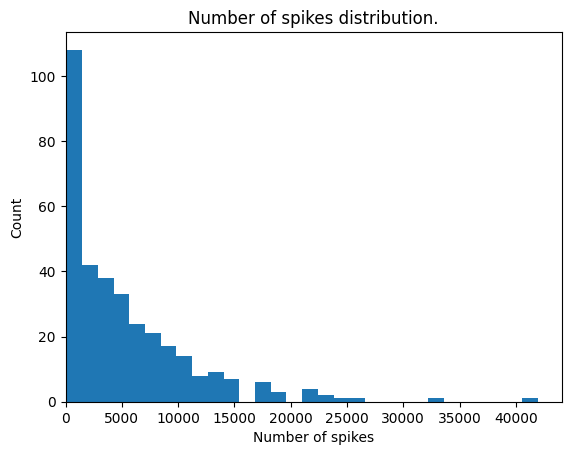

Mean: 5286.78
STD: 5777.55


In [136]:
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison

kilosort = Kilosort("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/spikesort_matlab4", "first", RECORDING)
kilosort.plot_nums_spikes(bins=30)
kilosort_spikes = np.unique(np.concatenate(kilosort.get_spike_times()))

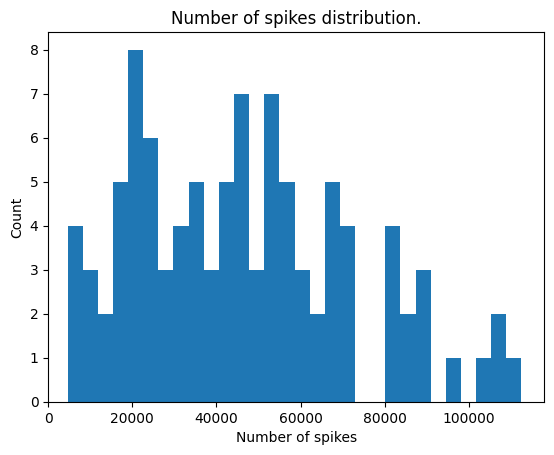

Mean: 46411.47
STD: 25623.22


In [140]:
propagations_merged, propagating_times_merged = merge(REL_AMP_MAX, return_times=True)
prop_signal = PropSignal([propagations_merged, propagating_times_merged], RECORDING)
prop_signal.plot_nums_spikes(bins=30)

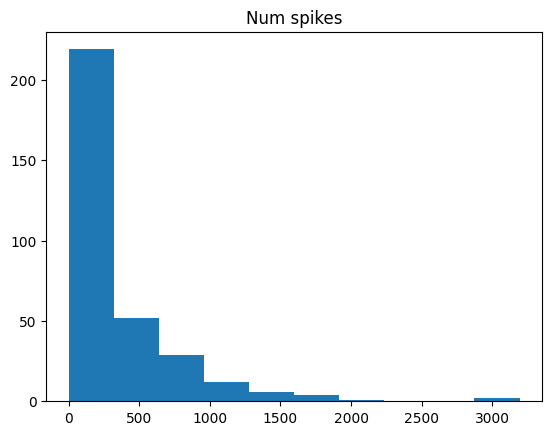

In [54]:
from src.sorters.kilosort import Kilosort
from src.comparison import DummySorter, Comparison

kilosort = Kilosort(
    "/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/spikesort_matlab4",
    "first",
    RECORDING
)

ks_times = []
for times in kilosort.get_spike_times():
    times = times[times < FIRST_SECONDS * 1000]
    if len(times) > 0:
        ks_times.append(times)
kilosort = DummySorter(ks_times, "Kilosort")

plt.title("Num spikes")
plt.hist([len(st) for st in ks_times])
plt.show()

In [86]:
# Num unique spikes
def count_unique_and_total_spikes(sorter):
    spikes_unique = set()
    total = 0
    for spikes in sorter.get_spike_times():
        spikes_unique.update(spikes)
        total += len(spikes)
    
    # return spikes_unique, spikes_total
    unique = len(spikes_unique)
    
    print(f"Unique/Total: {unique}/{total} = {unique/total*100:.1f}%")

# print("Kilosort:")
# count_unique_and_total_spikes(kilosort)
# print()
print("Prop:")
count_unique_and_total_spikes(prop_signal)

Prop:
Unique/Total: 36227/57537 = 63.0%


In [87]:
prop_spikes = np.unique(np.concatenate(prop_signal.get_spike_times()))
kilosort_spikes = np.unique(np.concatenate(kilosort.get_spike_times()))

In [88]:
matches = Comparison.count_matching_events(prop_spikes, kilosort_spikes)
print(matches/len(kilosort_spikes))
print(matches/len(prop_spikes))

0.27375544826319065
0.7403041930052171


Num Prop.: 119
Num Kilosort: 325
Num single matches: 47

For Prop.:
Num max matches: 53
Num unique max matches: 33

For Kilosort:
Num max matches: 80
Num unique max matches: 37


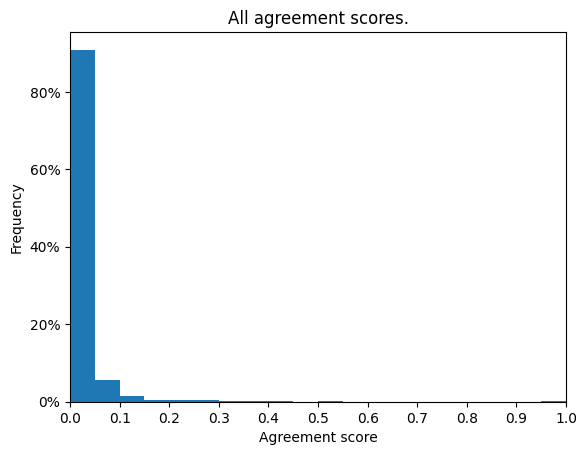

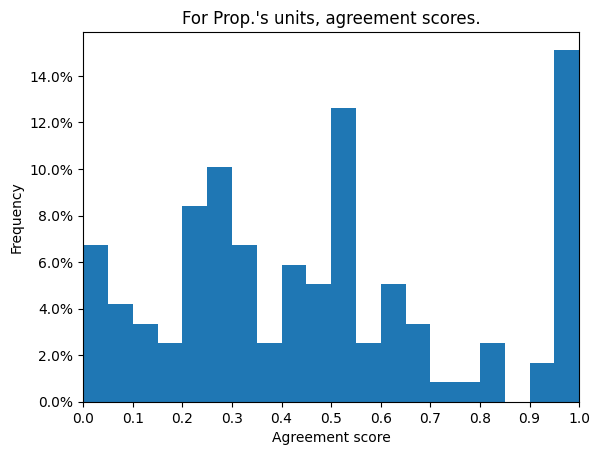

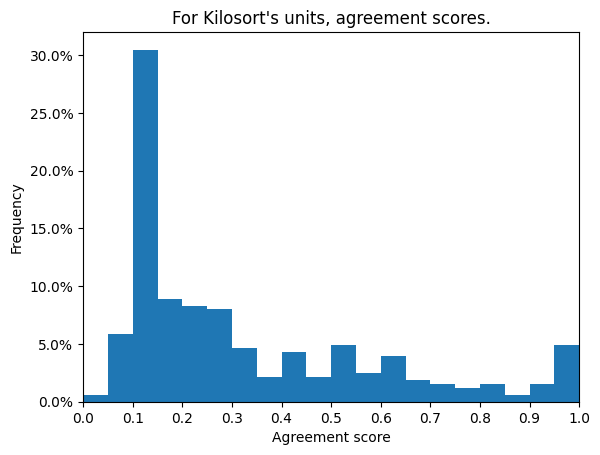

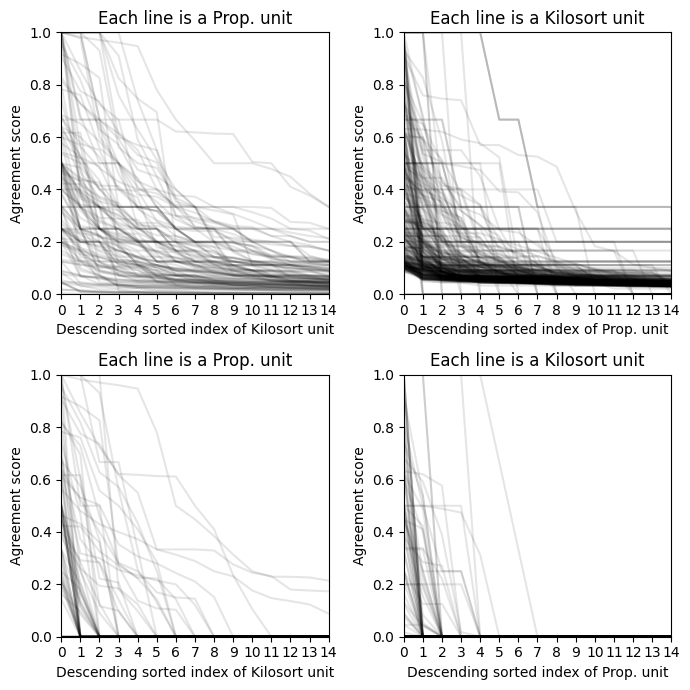

In [89]:
comp = Comparison(prop_signal, kilosort, score_formula=2, delta_time=1)
comp.summary()
comp.plot_line_comps()


In [ ]:
comp = Comparison(prop_signal, kilosort, score_formula=1, delta_time=1)
comp.summary()
comp.plot_line_comps()


## Disect

In [33]:
from IPython.display import display
from src.comparison import Comparison

In [34]:
from numpy.linalg import norm

def cos_sim(a, b):
    return np.dot(a, b)/(norm(a)*norm(b))

def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

FRONT_BUFFER = 40  # Model's front sample buffer
SAMP_FREQ = 30
num_window_frames = 30

def score_frame_to_time(frame):
    # Convert frame in spike_scores_all to ms from beginning of recording
    return ((frame + num_window_frames//2) + FRONT_BUFFER) / SAMP_FREQ

def score_frame_to_output_frame(frame):
    return frame + num_window_frames // 2

def output_frame_to_score_frame(frame):
    return frame - num_window_frames // 2

In [57]:
MODEL_OUTPUTS = np.load(MODEL_ROOT / "outputs.npy", mmap_mode="r")
SPIKE_SCORES = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120/230713/60_sec/spike_scores.npy", mmap_mode="r")

In [ ]:
# from scipy.signal import find_peaks

# MIN_SCORE = 0.575 # Minimum score needed for a frame to have a spike

# spike_times = []

# for idx in tqdm(range(len(unit_templates))):
#     scores = np.concatenate([[-np.inf], SPIKE_SCORES[idx, :], [-np.inf]]) # pad front and end in case peak occurs in beginning
#     peaks = find_peaks(scores, height=MIN_SCORE)[0] - 1  # -1 to account for padding
#     times = score_frame_to_time(peaks)
#     spike_times.append(np.sort(times))
    
#     # prop_amps = []
#     # rec_frames = peaks + num_window_frames//2 + FRONT_BUFFER
#     # for chan in propagations[idx].ID:
#     #     amps = RECORDING[chan, rec_frames]
#     #     prop_amps.append(np.mean(amps))
    
# # np.save(PROP_ROOT / f"propagating_times_{MIN_SCORE}.npy", np.array(spike_times, dtype=object))
# # np.save(PROP_ROOT / "propagating_amps.npy", np.array(spike_times, dtype=object))

0 823


[   ID   latency  small_window_cooccurrences  n1_n2_ratio
 0   2  0.000000                  150.000000     1.000000
 1   4  0.000000                   51.525106     0.931298
 2   3  0.033333                   49.906147     0.954240]

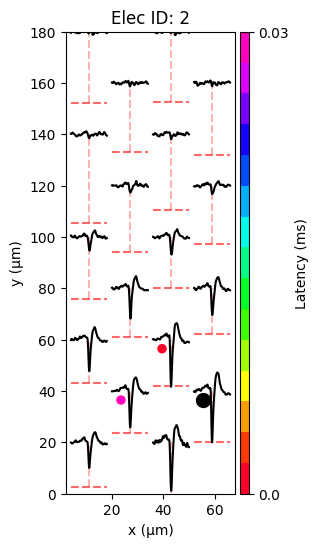

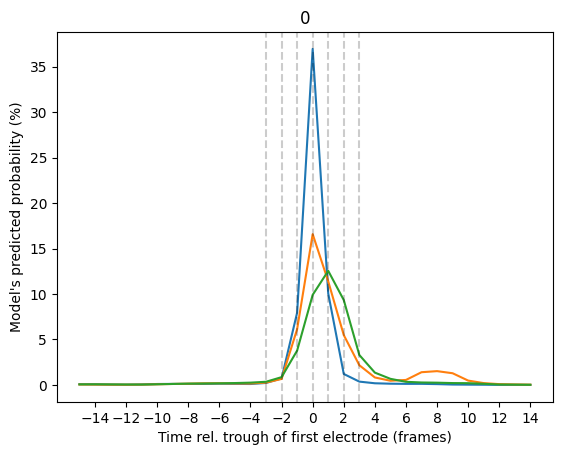

In [40]:
UNIT_1 = prop_signal.get_unit(2)
idx = prop_signal.get_idx(UNIT_1)
print(idx, len(UNIT_1))
display(UNIT_1.df)
UNIT_1.plot_footprint(chans_rms=chans_rms)
plot_template(idx)

In [44]:
# NIT_1.chans
CHANS = [2, 4, 3, 0, 1] #, 2, 3, 4, 5]
COLORS = ["red", "orange", "green", "blue", "purple", "magenta"]

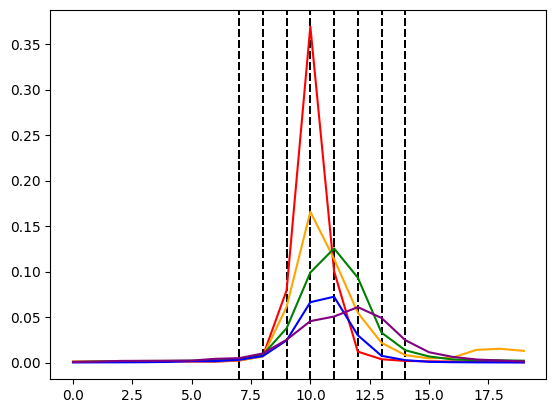

'Mean'

In [47]:
all = []
for time in propagating_times[idx]:
    output_frame = time_to_output_frame(time)
    outputs = MODEL_OUTPUTS[:, output_frame-10:output_frame+10]
    outputs = sigmoid(outputs)
    
    # score = cos_sim(outputs.flatten(), unit_templates[idx].flatten())
    # plt.title(f"{output_frame}, {score}")
    
    # for i, chan in enumerate(CHANS):
    #     plt.plot(outputs[chan], c=COLORS[i], alpha=0.1)
    all.append(outputs[CHANS])
    
    for x in [7, 8, 9, 10, 11, 12, 13, 14]:
        plt.axvline(x, color="black", linestyle="dashed", alpha=0.01)

all = np.array(all)
all = np.mean(all, axis=0)
for i, temp in enumerate(all):
    plt.plot(temp, color=COLORS[i])
plt.show()


"""Mean"""

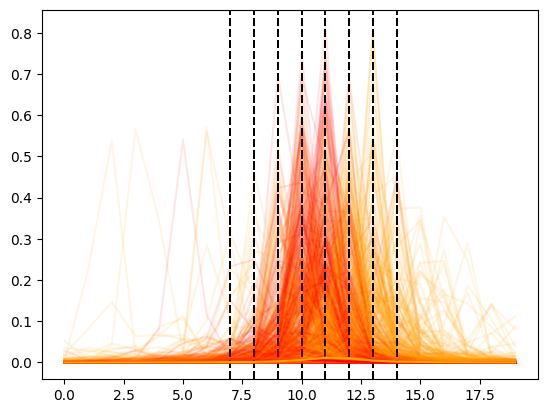

'\n\nMedian -> sharper peaks, due to only 10 sec?\n\n'

In [43]:
all = []
for time in propagating_times[idx]:
    output_frame = time_to_output_frame(time)
    outputs = MODEL_OUTPUTS[:, output_frame-10:output_frame+10]
    outputs = sigmoid(outputs)
    
    # score = cos_sim(outputs.flatten(), unit_templates[idx].flatten())
    # plt.title(f"{output_frame}, {score}")
    
    # for i, chan in enumerate(CHANS):
    #     plt.plot(outputs[chan], c=COLORS[i], alpha=0.1)
    all.append(outputs[CHANS])
    
    for x in [7, 8, 9, 10, 11, 12, 13, 14]:
        plt.axvline(x, color="black", linestyle="dashed", alpha=0.01)

all = np.array(all)
all = np.median(all, axis=0)
for i, temp in enumerate(all[CHANS]):
    plt.plot(temp, color=COLORS[i])
plt.show()

"""

Median -> sharper peaks, due to only 10 sec?

"""

In [59]:
spike_scores = SPIKE_SCORES[idx]
frames_sorted = np.argsort(spike_scores)

In [60]:
frame = frames_sorted[-1]
spike_scores[frame]

0.7446

In [61]:
CHANS = [2, 4, 3, 0, 1, 5]
COLORS = ["red", "orange", "green", "blue", "purple", "magenta"]

0.774
0.354


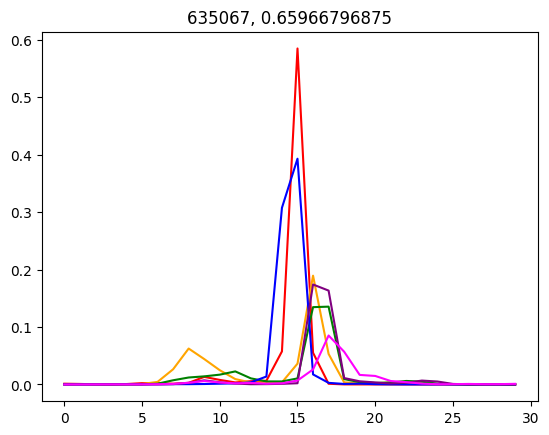

0.785
0.2876


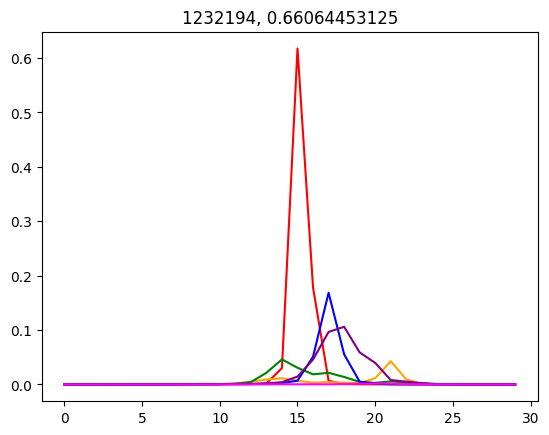

0.8296
0.3542


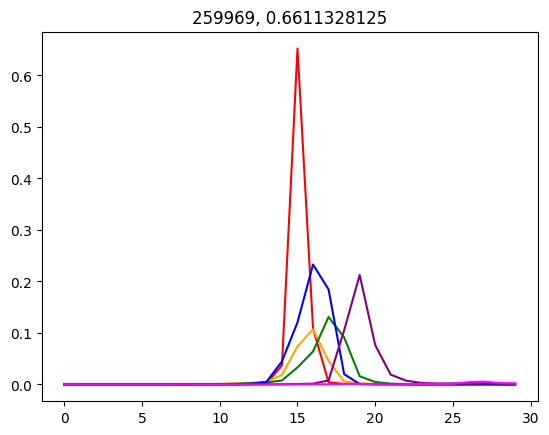

0.7793
0.1989


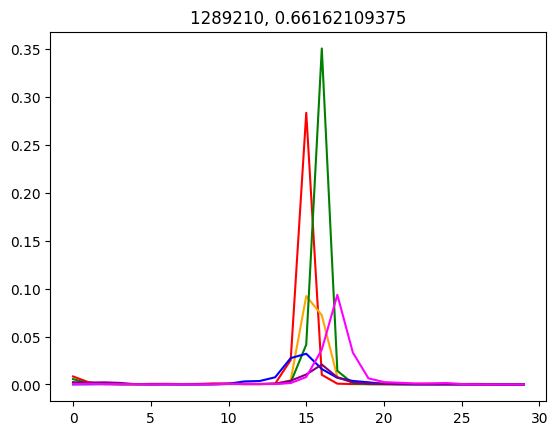

0.847
0.268


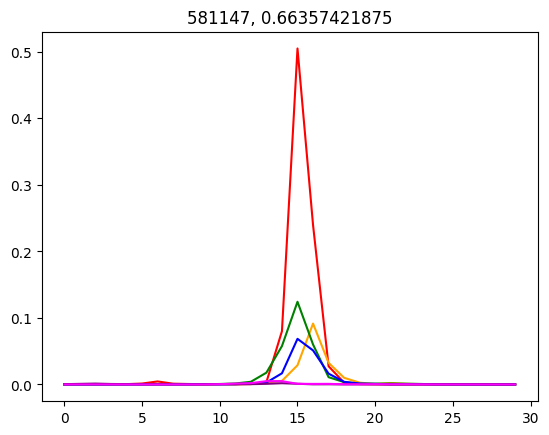

0.802
0.4023


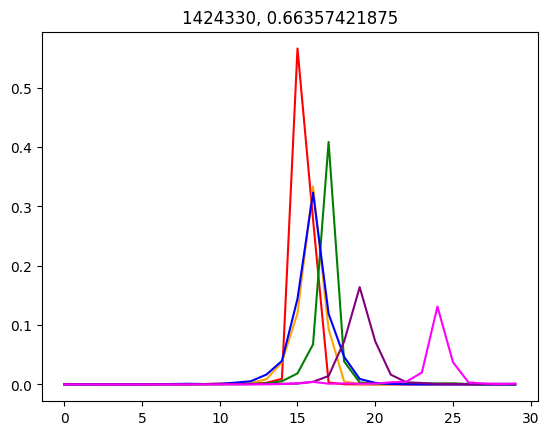

0.8237
0.4502


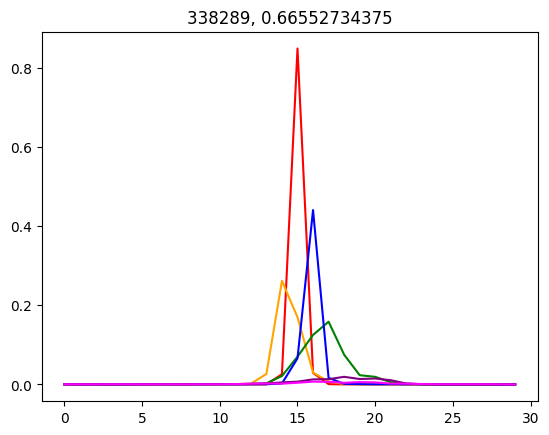

0.7573
0.363


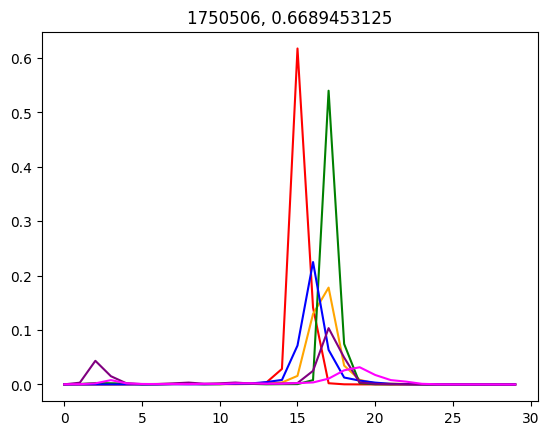

0.767
0.263


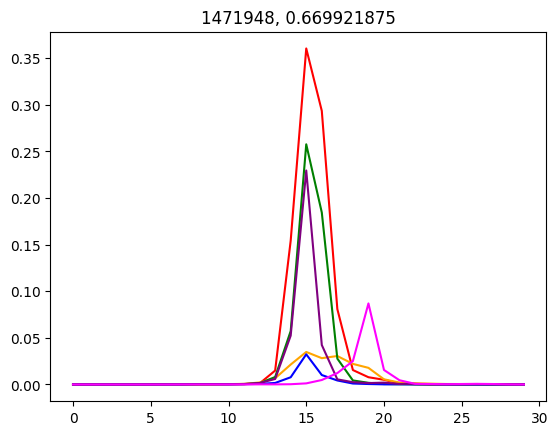

0.812
0.2595


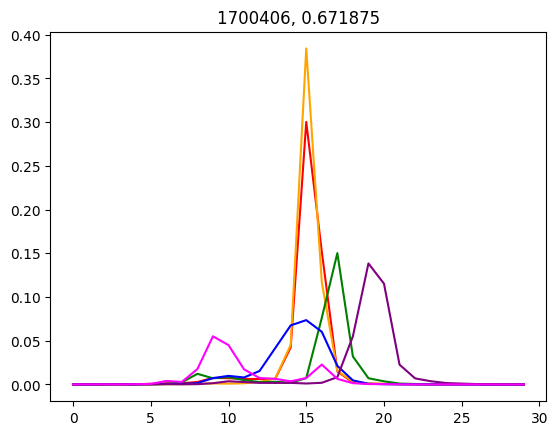

0.8677
0.3665


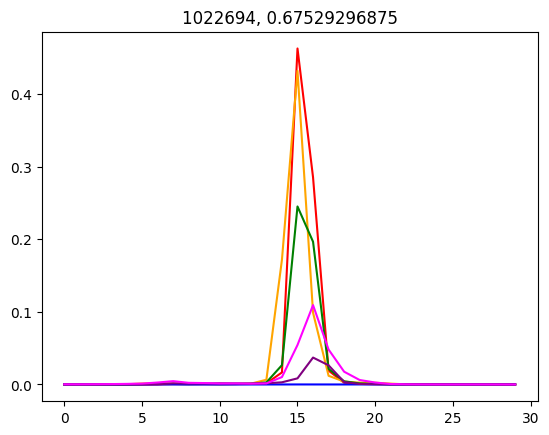

0.8857
0.3723


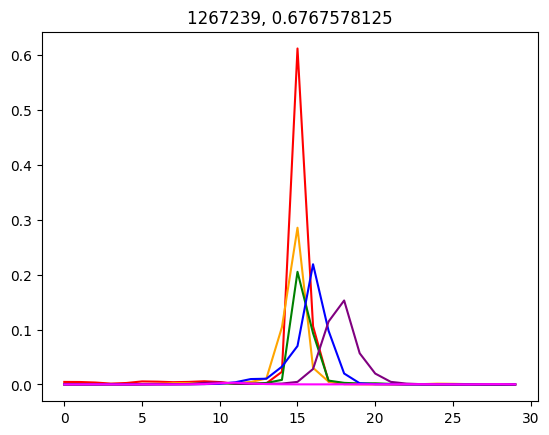

0.7715
0.2297


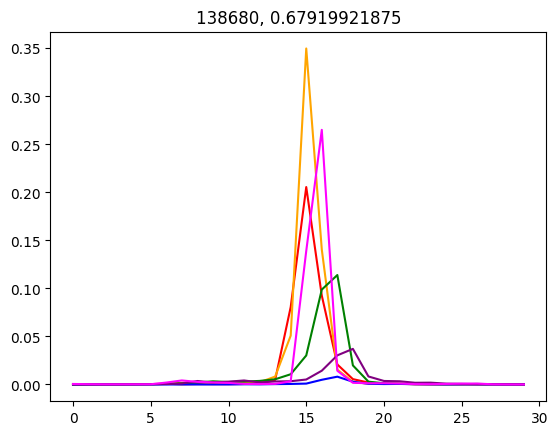

0.8423
0.4878


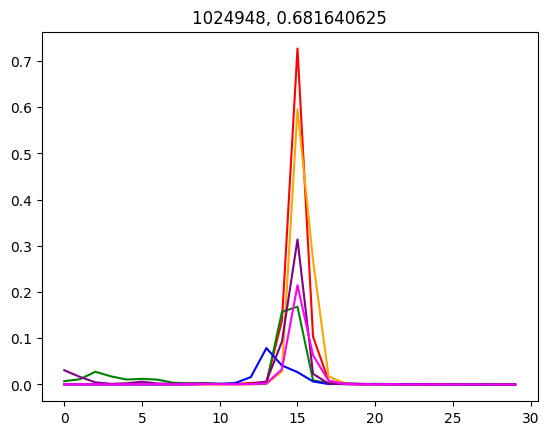

0.79
0.386


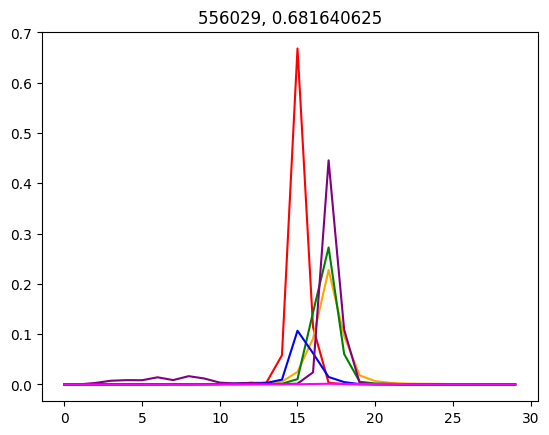

0.843
0.2607


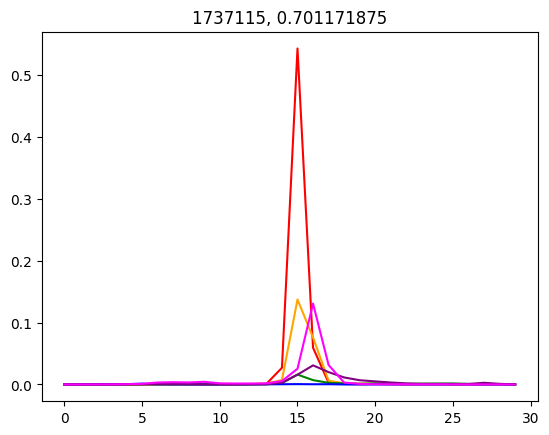

0.8174
0.3613


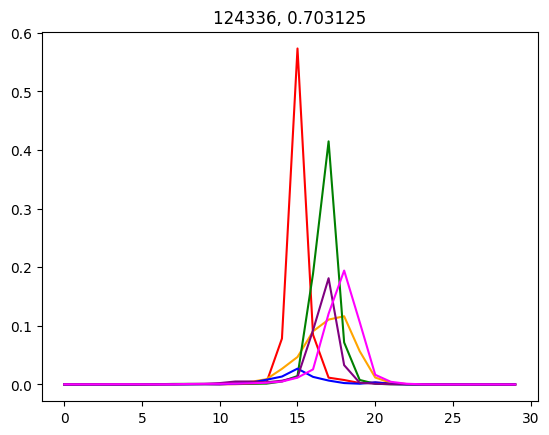

0.8486
0.309


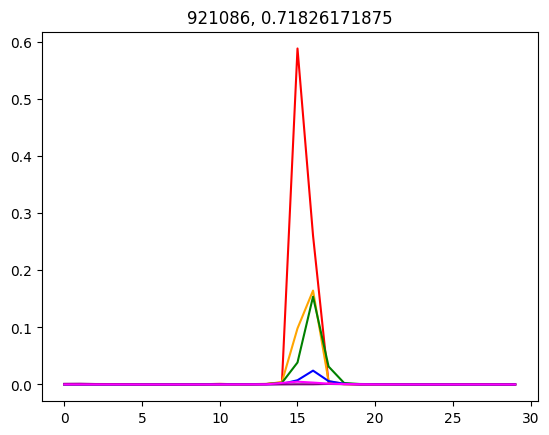

0.866
0.481


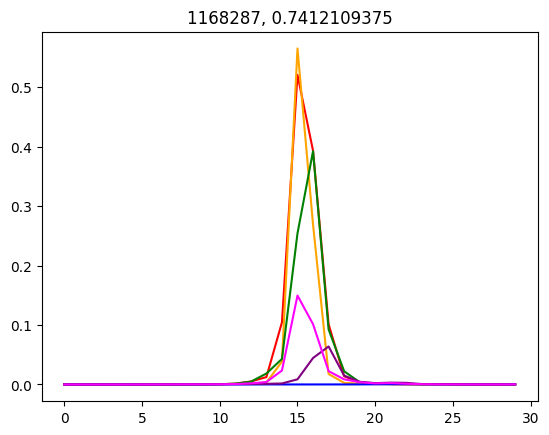

0.863
0.4429


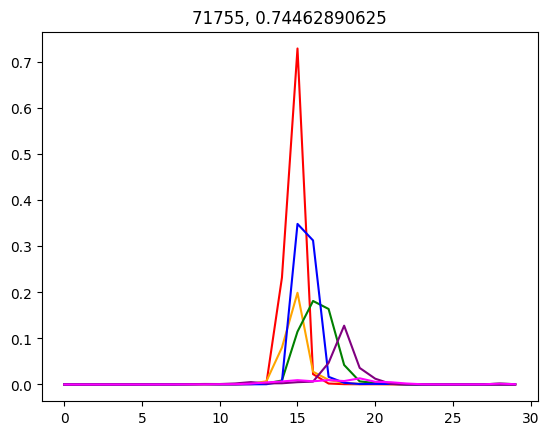

In [66]:
unit_templates_chans = unit_templates[idx, CHANS]
for frame in frames_sorted[-20:]:

    output_frame = score_frame_to_output_frame(frame)
    outputs = MODEL_OUTPUTS[:, output_frame-15:output_frame+15]
    outputs = sigmoid(outputs)
    
    outputs = outputs[CHANS]

    # Scores if only using channels that are plotted
    score = cos_sim(outputs.flatten(), unit_templates_chans.flatten())
    print(score)
    
    score = np.dot(outputs.flatten(), unit_templates_chans.flatten())
    print(score)
    
    for i, chan in enumerate(CHANS):
        plt.plot(outputs[i], color=COLORS[i])
        # plt.plot(unit_templates[idx, chan, :], alpha=0.5, color=COLORS[i], linestyle="dashed", zorder=20)
    
    # Score of cos similarity of all channels
    plt.title(f"{output_frame}, {spike_scores[frame]}")
    plt.show()

In [130]:
outputs.shape

(384, 0)

In [ ]:
STRIDE = 1

# num_chans, num_output_frames = MODEL_OUTPUTS.shape
num_output_frames = int(FIRST_SECONDS * 1000 * RECORDING.get_sampling_frequency() - 80) # 80 = 2 * FRONT_BUFFER
num_window_frames = unit_templates.shape[2]

class OutputDataset:
    """Class to get output windows from MODEL_OUTPUTS to extract spike times"""
    def __init__(self):
        # super().__init__()
        
        # self.start_frames_all = np.arange(0, num_output_frames-num_window_frames+1, STRIDE)
        self.start_frames_all = np.arange(0, num_output_frames-num_window_frames+1, STRIDE)

    def __len__(self):
        return len(self.start_frames_all)
    
    def __getitem__(self, idx):
        start_frame = self.start_frames_all[idx]
        return MODEL_OUTPUTS[:, start_frame:start_frame+num_window_frames].flatten() # , start_frame
        
# print("Extracting spike scores ...")
# spike_scores = []
# output_dataset = OutputDataset()

# for i in tqdm(range(len(output_dataset))):
#     window = sigmoid(output_dataset[i])
    

8 498


[   ID   latency  small_window_cooccurrences  n1_n2_ratio
 0  19  0.000000                  150.000000     1.000000
 1  17  0.000000                   91.490964     0.931034
 2  21  0.000000                   90.135542     0.913043
 3  16  0.000000                   62.575301     0.908197
 4  20  0.033333                   82.003012     0.896296
 5  23  0.033333                   54.894578     0.843750]

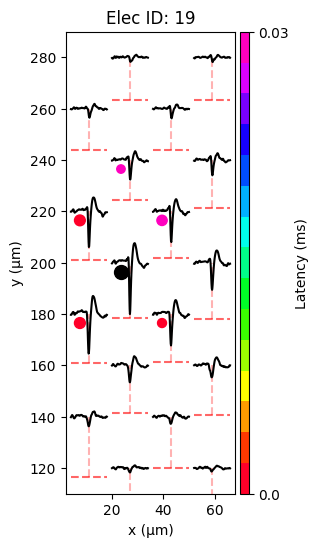

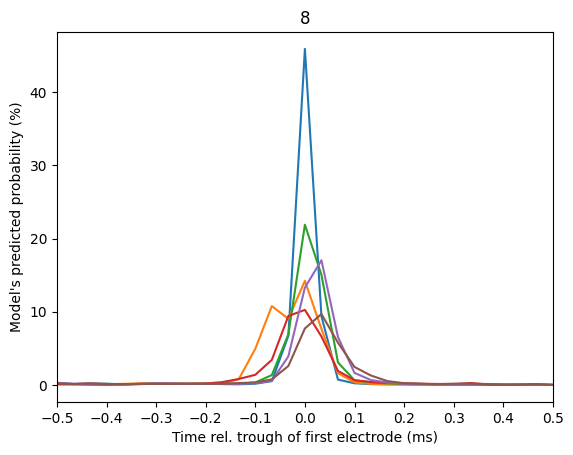

In [81]:
UNIT_2 = prop_signal.get_unit(19)
idx = prop_signal.get_idx(UNIT_2)
print(idx, len(UNIT_2))
display(UNIT_2.df)
UNIT_2.plot_footprint(chans_rms=chans_rms)
plot_template(idx)

In [86]:
matchings = Comparison.get_matching_spikes(UNIT_1.spike_train, UNIT_2.spike_train)

len(matchings)

3